In [1]:
import h5py
import pandas as pd 

import sys 
sys.path.append('/scratch/m/murray/dtolgay')
 
from tools import constants # type: ignore
from matplotlib import pyplot as plt


In [2]:
def read_gas_particles_from_hdf5(file_path: str) -> pd.DataFrame:
    
    with h5py.File(file_path, 'r') as f:
        part_group = f['PartType0']

        # Load vector quantities
        # p = part_group['p'][:]   # shape (N, 3)
        # v = part_group['v'][:]

        # Load scalar quantities
        # m = part_group['m'][:]
        # rho = part_group['rho'][:]
        # h = part_group['h'][:]
        # sfr = part_group['sfr'][:]
        # u = part_group['u'][:]
        T = part_group['T'][:]
        hden = part_group['hden'][:]
        # isrf = part_group['isrf_skirt'][:] 
        z = part_group['z'][:]          # shape (N, 11)
        Nh = part_group['Nh'][:]

    # Build dataframe
    df = pd.DataFrame({
        # 'x': p[:, 0],
        # 'y': p[:, 1],
        # 'z': p[:, 2],
        # 'vx': v[:, 0],
        # 'vy': v[:, 1],
        # 'vz': v[:, 2],
        # 'mass': m,
        # 'density': rho,
        # 'smoothing_length': h,
        # 'star_formation_rate': sfr,
        # 'internal_energy': u,
        'temperature': T,
        'hden': hden,
        # 'isrf': isrf,
        'metallicity': z[:, 0],
        'He_mass_fraction': z[:, 1],
        'C_mass_fraction': z[:, 2],
        'N_mass_fraction': z[:, 3],
        'O_mass_fraction': z[:, 4],
        'Ne_mass_fraction': z[:, 5],
        'Mg_mass_fraction': z[:, 6],
        'Si_mass_fraction': z[:, 7],
        'S_mass_fraction': z[:, 8],
        'Ca_mass_fraction': z[:, 9],
        'Fe_mass_fraction': z[:, 10],
        'Nh': Nh,
    })

    return df


def combine_chimes_hdf5_files(path_to_chimes_file: str, gas_particles_before_chimes: pd.DataFrame) -> pd.DataFrame:

    C_over_H_number_ratio = 2.51e-4 # ~ C/H /home/m/murray/dtolgay/cloudy/c23.00/data/abundances/ISM.abn 


    with h5py.File(path_to_chimes_file, 'r') as f:
        after_chimes = f['EqmChemistryAbundances'][:]  # Load the dataset into a NumPy array

    chimes = gas_particles_before_chimes.copy()

    nco_over_nh = after_chimes[:, 148]  # Get all rows of column 148
    nco_over_nc = nco_over_nh / C_over_H_number_ratio
    nh2_over_nh = after_chimes[:, 137]  # Get all rows of column 137
    noh_over_nh = after_chimes[:,140]

    nh_chimes = after_chimes[:,1] + after_chimes[:,2] + after_chimes[:,3] + after_chimes[:,137]*2
    chimes['nh_chimes'] = nh_chimes


    chimes['nco/nc'] = nco_over_nc
    chimes['nco/nh'] = nco_over_nh
    chimes['nh2/nh'] = nh2_over_nh
    chimes['noh/nh'] = noh_over_nh
    chimes['noh/no'] = chimes['noh/nh'] * 3e-4

    chimes['nco'] = chimes['nco/nh'] * 100 # cm-3
    chimes['ncox100'] = chimes['nco/nh'] * 100 * 100 # cm-3
    chimes['ncox1000'] = chimes['nco/nh'] * 100 * 1000 # cm-3


    # Calculate the mass fraction of H2 and CO
    chimes['fCO'] = nco_over_nh * constants.mco_molecular_mass 
    chimes['fH2'] = nh2_over_nh * constants.mh2_molecular_mass


    return chimes 

In [14]:
def read_ovr_file(center: pd.DataFrame, train_data_file_path: str) -> pd.DataFrame:
    
    # Define the path to the ovr file 
    fdir = get_fdir(center)
    path_to_ovr_file = f"{train_data_file_path}/{fdir}/{fdir}.ovr"

    # Read the ovr file
    ovr_file = pd.read_csv(path_to_ovr_file, sep='\s+')
    ovr_file.rename(columns={'#depth': 'depth'}, inplace=True)
    ovr_file['Nh'] = ovr_file['hden'] * ovr_file['depth'] # cm2

    return ovr_file


def get_fdir(center: pd.DataFrame) -> str:
    return f"hden{center['log_hden']:.5f}_metallicity{center['log_metallicity']:.5f}_turbulence{center['log_turbulence']:.5f}_isrf{center['log_isrf']:.5f}_radius{center['log_radius']:.5f}"


center = {
    "log_hden": 2.0,
    "log_metallicity": 0.0,
    "log_turbulence": 0.0,
    "log_isrf": 0.0,
    "log_radius": 3.0,
}

train_data_file_path = "/scratch/m/murray/dtolgay/cloudy_runs/z_0/cr_1_CO87_CII_H_O3/cr_1_CO87_CII_H_O3_metallicity_above_minus_2"

cloudy = read_ovr_file(center, train_data_file_path)

In [25]:
base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/test"

# Read the hdf5 file 
before_chimes_path = f"{base_fdir}/Zsolar_nh100_T300_varyingNh.hdf5"
print(f"Before chimes file path: {before_chimes_path}")
before_chimes = read_gas_particles_from_hdf5(file_path = before_chimes_path)

after_chimes_path = f"{base_fdir}/Zsolar_nh100_T300_varyingNh_chimes.hdf5"
data = combine_chimes_hdf5_files(path_to_chimes_file=after_chimes_path, gas_particles_before_chimes=before_chimes.copy())


after_chimes_path = f"{base_fdir}/Zsolar_nh100_T300_varyingNh_ForceEq_chimes.hdf5"
data_eq = combine_chimes_hdf5_files(path_to_chimes_file=after_chimes_path, gas_particles_before_chimes=before_chimes.copy())

Before chimes file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/test/Zsolar_nh100_T300_varyingNh.hdf5


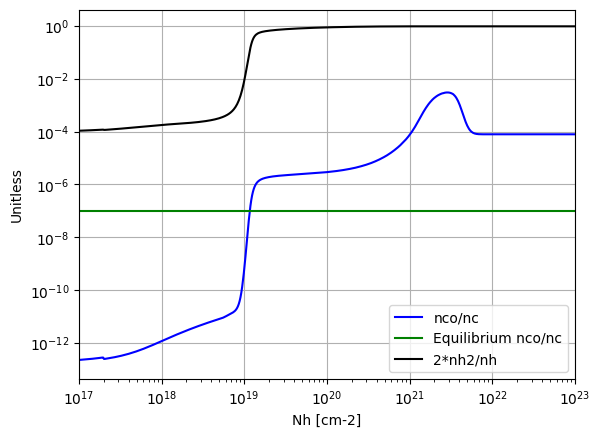

In [26]:
plt.plot(
    data['Nh'], 
    data['nco/nc'],
    label='nco/nc',
    color='blue',
)

plt.plot(
    data_eq['Nh'], 
    data_eq['nco/nc'],
    label='Equilibrium nco/nc',
    color='green',
)

# plt.plot(
#     cloudy['Nh'],
#     cloudy['CO/C'],
#     label="cloudy CO/C",
# )

# plt.plot(
#     data['Nh'], 
#     data['nco/nh'],
#     label='nco/nh',
# )

plt.plot(
    data['Nh'], 
    2*data['nh2/nh'],
    label='2*nh2/nh',
    color='black',
)

# plt.plot(
#     data['Nh'], 
#     data['noh/no'],
#     label='noh/no',
# )

# plt.plot(
#     data['Nh'], 
#     data['nh_chimes'],
#     label='nh_chimes',
# )


plt.xlim([1e17, 1e23])

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel("Nh [cm-2]")
plt.ylabel("Unitless")

plt.grid()

In [ ]:
plt.scatter(
    data['Nh'], 
    data['nco'],
    label = "nco",
)

plt.scatter(
    data['Nh'], 
    data['ncox100'],
    label = "nco x 1e2",
)

plt.scatter(
    data['Nh'], 
    data['ncox1000'],
    label = "nco x 1e3",
)


plt.xscale('log')
plt.yscale('log')
plt.xlabel("Nh [cm-2]")
plt.ylabel("nco [cm-3]")

plt.legend()

# Delete below 

In [24]:
print(data.columns)

data[['hden', 'metallicity', 'temperature']]

Index(['temperature', 'hden', 'metallicity', 'He_mass_fraction',
       'C_mass_fraction', 'N_mass_fraction', 'O_mass_fraction',
       'Ne_mass_fraction', 'Mg_mass_fraction', 'Si_mass_fraction',
       'S_mass_fraction', 'Ca_mass_fraction', 'Fe_mass_fraction', 'Nh',
       'nh_chimes', 'nco/nc', 'nco/nh', 'nh2/nh', 'noh/nh', 'noh/no', 'nco',
       'ncox100', 'ncox1000', 'fCO', 'fH2'],
      dtype='object')


,hden,metallicity,temperature
0,100.0,0.02,300.0
1,100.0,0.02,300.0
2,100.0,0.02,300.0
3,100.0,0.02,300.0
4,100.0,0.02,300.0
...,...,...,...
995,100.0,0.02,300.0
996,100.0,0.02,300.0
997,100.0,0.02,300.0
998,100.0,0.02,300.0
